In [35]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

#For loading dataset & for linear algebra
import pandas as pd
import numpy as np

import os
import zipfile
import cv2
from skimage import io
from utilities import rle2mask, mask2rle, prediction, focal_tversky, tversky_loss, tversky, DataGenerator
from IPython.display import display

# Feature engineering & preprocessing
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split

#Visualization of data & statistical analysis
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Tensorflow
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K

In [2]:
# Load dataset with defects and segmentation masks
defect_class_mask_df = pd.read_csv('/Colab Notebooks/Segmentation/train.csv')

In [3]:
# Load df with all images
all_images_df = pd.read_csv('/Colab Notebooks/Segmentation/defect_and_no_defect.csv')

In [5]:
# Show dataset with defects
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


We have 3 features: id of image, id of class and encoded pixels (defect masks)

*** One image may have several defects

In [6]:
# Show dataset with all images
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


1 - defect o, 0 - defect x

In [4]:
# Count defects
# If ClassId is present then defect is present too, if we have defect so we have mask too
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [5]:
# Show first 20 rows of df
defect_class_mask_df.head(20)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


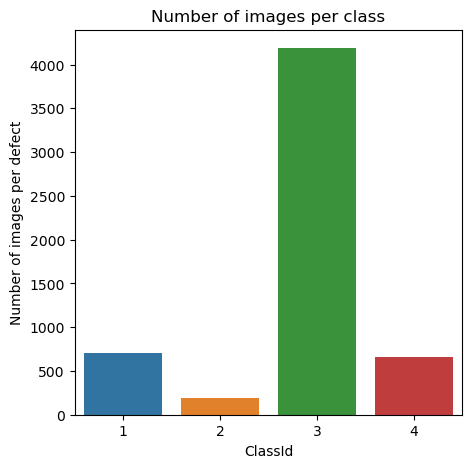

In [10]:
# Visualize number of images per class

plt.figure(figsize = (5, 5))
sns.countplot(defect_class_mask_df['ClassId'])
plt.ylabel('Number of images per defect')
plt.xlabel('ClassId')
plt.title('Number of images per class')
plt.show()

We see that there is most of the type 3 defect (about 4100). Then type 1, 4 and type 2 at least.

In [11]:
# Count values of defects in image
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()

In [12]:
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

We have one image with 3 defects, 272 images with 2 defects and 5201 images with only 1 defect.

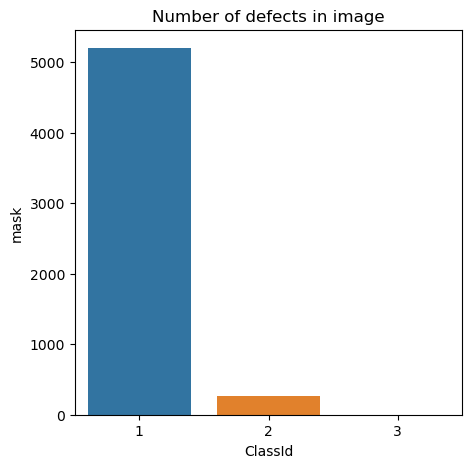

In [13]:
# Visualize number of defects in image

plt.figure(figsize = (5, 5))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts())
plt.xlabel('ClassId')
plt.title('Number of defects in image')
plt.show()

In [6]:
defect_class_mask_df.shape

(5748, 4)

In [7]:
all_images_df.shape

(12997, 2)

In [8]:
# Count images per class
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

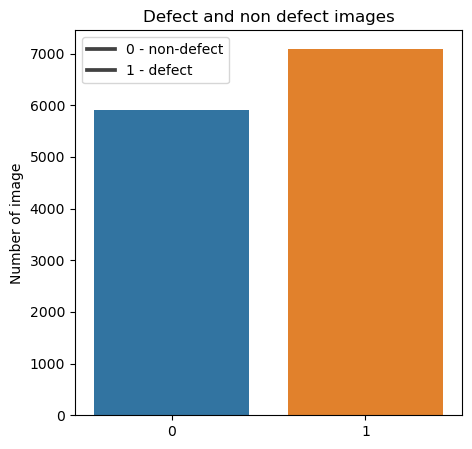

In [20]:
# Visualize count of images per class

xticks = ['0 - non-defect', '1 - defect']
plt.figure(figsize = (5, 5))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts())
plt.ylabel('Number of image')
plt.legend(labels = xticks)
plt.title('Defect and non defect images')
plt.show()

As we can see dataset is not balanced and difference is not large (about 1000 images).

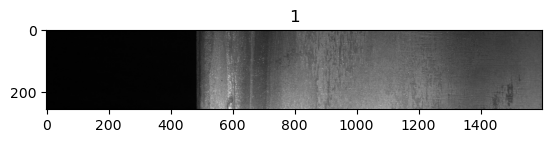

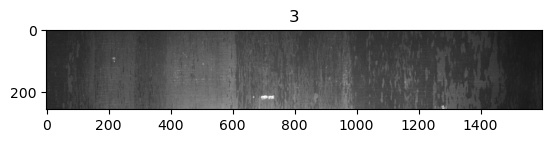

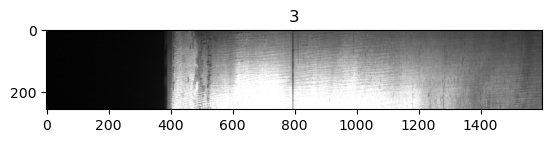

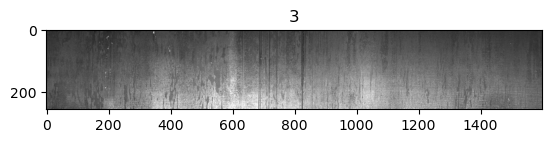

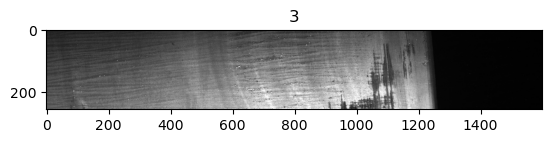

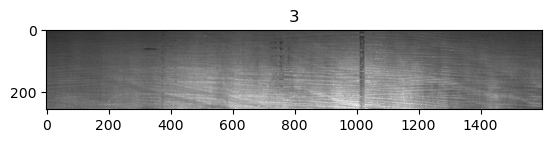

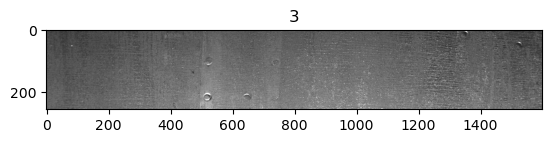

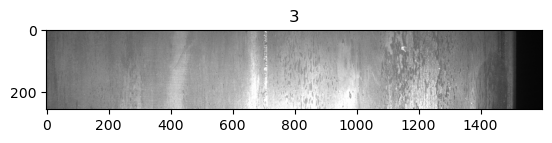

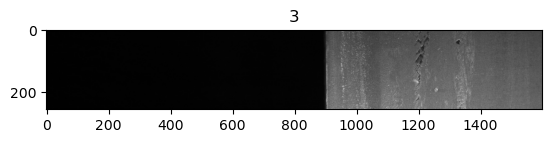

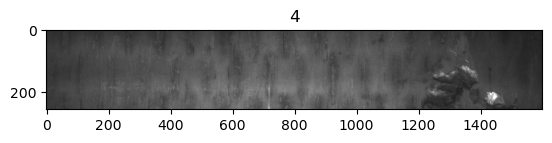

In [8]:
# Visualize our 10 images with class of defect

train_dir = '/Colab Notebooks/Segmentation/train_images/'

for i in range(10):
    img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
    plt.figure()
    plt.title(defect_class_mask_df.ClassId[i])
    plt.imshow(img)

In [6]:
# change directory to our folder Segmentation
%cd /Users/OlgaKim/Мой диск (okim7679@gmail.com)/Colab Notebooks/Segmentation

/Users/OlgaKim/Мой диск (okim7679@gmail.com)/Colab Notebooks/Segmentation


In [9]:
# Visualize mask to know where is the defect from utilities file
# Run Length Encoding for mask

image_index = 20

mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])

mask.shape

(256, 1600)

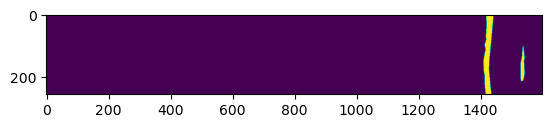

In [27]:
# Image with defect mask
plt.imshow(mask)

Here we can see the defect location (yellow lines)

(256, 1600, 3)

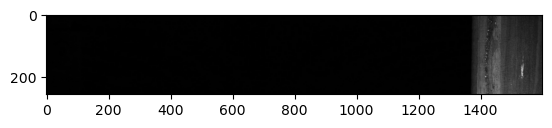

In [28]:
# Original image without mask

img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

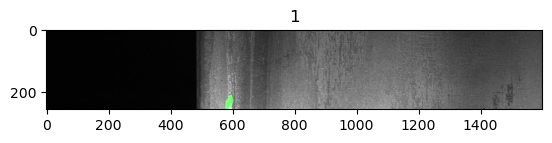

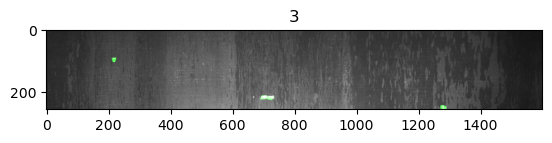

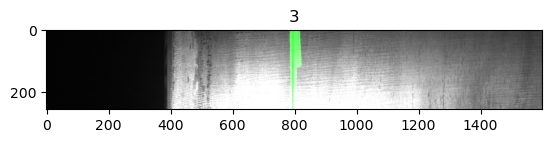

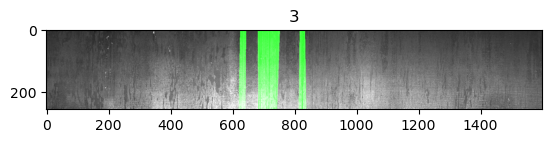

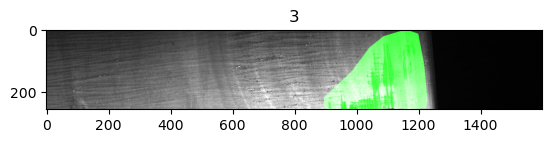

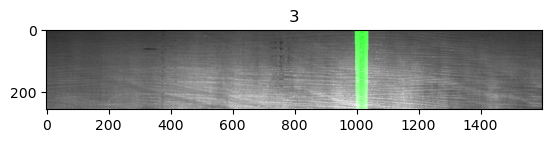

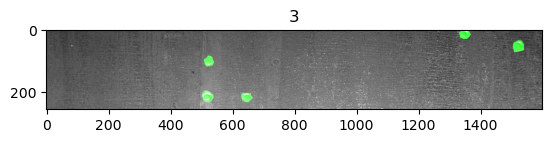

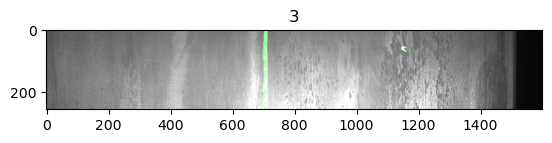

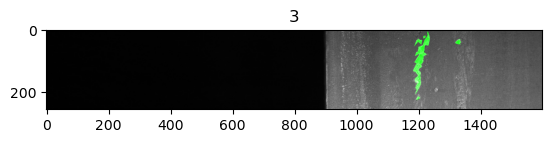

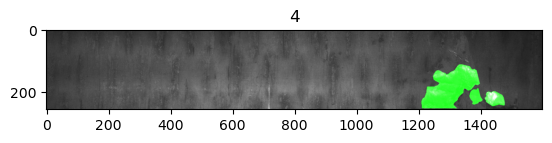

In [29]:
# Let show first 10 images with mask defect on them

for i in range(10):
    img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])
    img[mask == 1, 1] = 255
    plt.figure()
    plt.imshow(img)
    plt.title(defect_class_mask_df.ClassId[i])

We can check now the locations of defects. They highlighted with green color.

In [ ]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


### Our strategies:

1. Classification: 
 - if defect is present, then step 2, 
 - if we have no defect, then go to end
2. ResUNet segmentation model

In [12]:
# Split dataset on train and test sets
train, test = train_test_split(all_images_df, test_size = 0.20)

In [13]:
# Check shape of train and test sets
train.shape, test.shape

((10397, 2), (2600, 2))

In [14]:
# Define ImageGenerator
datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.15)

In [15]:
# Define ImageGenerator for train, validation and test sets

train_generator = datagen.flow_from_dataframe(
    dataframe = train, 
    directory = train_dir, 
    x_col = 'ImageID', 
    y_col = 'label', 
    subset = 'training', 
    batch_size = 16,   
    shuffle = True, 
    class_mode = 'other', 
    target_size = (256, 256)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe = train, 
    directory = train_dir, 
    x_col = 'ImageID', 
    y_col = 'label', 
    subset = 'validation', 
    batch_size = 16, 
    shuffle = True, 
    class_mode = 'other', 
    target_size = (256, 256)
)

Found 8838 validated image filenames.
Found 1559 validated image filenames.


In [16]:
test_datagen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test, 
    directory = train_dir, 
    x_col = 'ImageID', 
    y_col = None, 
    batch_size = 16, 
    shuffle = False, 
    class_mode = None, 
    target_size = (256, 256)
)

Found 2600 validated image filenames.


In [17]:
# Define basemodel 
basemodel = ResNet50(weights = 'imagenet', 
                     include_top = False, 
                     input_tensor = Input(shape = (256, 256, 3)))

2023-03-11 13:31:21.181652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-11 13:31:21.181806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [36]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [18]:
# Freeze convolution layers

for layer in basemodel.layers:
    layer.trainable = False

In [19]:
# Define model

headmodel = basemodel.output

headmodel = MaxPool2D(pool_size = (4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)

headmodel = Dropout(0.3)(headmodel)

headmodel = Dense(1, activation = 'sigmoid')(headmodel)

# Group inputs and outputs into one model
model = Model(inputs = basemodel.input, outputs = headmodel)

In [20]:
# Compile model

model.compile(loss = 'binary_crossentropy', 
              optimizer = 'Nadam', 
              metrics = ['accuracy'])

In [21]:
# Define callbacks

earlystopping = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 1, 
    patience = 10
)

checkpointer = ModelCheckpoint(
    filepath = 'resnet-weights.hdf5', 
    verbose = 1, 
    save_best_only = True
)

In [22]:
# Fit the model

history = model.fit(
    train_generator, 
    steps_per_epoch = train_generator.n//16, 
    epochs = 40, 
    validation_data = valid_generator, 
    validation_steps = valid_generator.n//16, 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/40


2023-03-11 13:31:31.864370: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-11 13:31:33.264438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


552/552 [==============================] - ETA: 0s - loss: 0.7854 - accuracy: 0.6075

2023-03-11 13:33:32.544599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.63679, saving model to resnet-weights.hdf5
552/552 [==============================] - 141s 252ms/step - loss: 0.7854 - accuracy: 0.6075 - val_loss: 0.6368 - val_accuracy: 0.6469
Epoch 2/40
552/552 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.6517
Epoch 2: val_loss improved from 0.63679 to 0.61309, saving model to resnet-weights.hdf5
552/552 [==============================] - 139s 251ms/step - loss: 0.6293 - accuracy: 0.6517 - val_loss: 0.6131 - val_accuracy: 0.6695
Epoch 3/40
552/552 [==============================] - ETA: 0s - loss: 0.6119 - accuracy: 0.6691
Epoch 3: val_loss did not improve from 0.61309
552/552 [==============================] - 140s 253ms/step - loss: 0.6119 - accuracy: 0.6691 - val_loss: 0.6333 - val_accuracy: 0.6488
Epoch 4/40
552/552 [==============================] - ETA: 0s - loss: 0.6050 - accuracy: 0.6717
Epoch 4: val_loss improved from 0.61309 to 0.59470, saving model to resnet-weights.hdf5

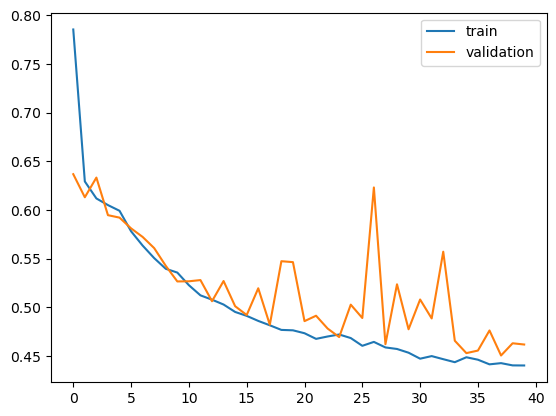

In [23]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()
plt.show()

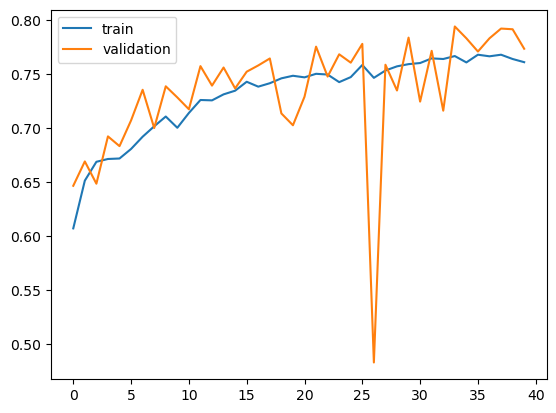

In [24]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.legend()
plt.show()

In [25]:
# save architecture of trained model

model_json = model.to_json()

with open('resnet-classifier-model.json', 'w') as json_file:
    json_file.write(model_json)

In [26]:
# Load saved model: architecture and weights

with open('./resnet-classifier-model.json', 'r') as json_file:
    json_savedModel = json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)

model.load_weights('./resnet-weights.hdf5')

model.compile(loss = 'binary_crossentropy', optimizer = 'Nadam', metrics = ['accuracy'])

In [27]:
# Predict test
test_predict = model.predict(test_generator, steps = test_generator.n//16, verbose = 1)

2023-03-11 15:04:58.254311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - 34s 204ms/step


In [28]:
# Define predict results. If predict result is less than 50% then 0 - we don't have defect and vice versa

predict = []
for i in test_predict:
    if i < 0.5:
        predict.append(0)
    else:
        predict.append(1)

predict = np.asarray(predict)

In [29]:
predict

array([1, 1, 1, ..., 1, 0, 0])

In [30]:
len(predict)

2592

In [32]:
# We need only 1936 images
original = np.asarray(test.label)[:2592]
len(original)

2592

In [33]:
# Show accuracy score

accuracy = accuracy_score(original, predict)
round(accuracy, 3)

0.786

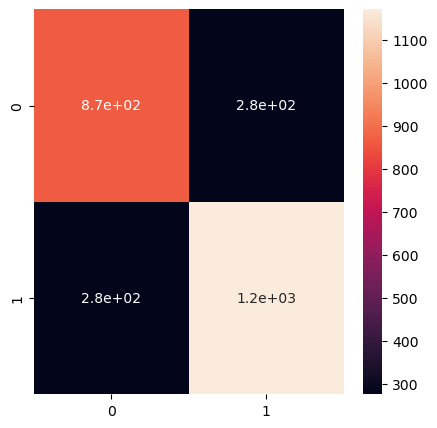

In [37]:
# Visualize confusion matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (5, 5))
sns.heatmap(cm, annot = True)
plt.show()

In [38]:
cm

array([[ 866,  276],
       [ 278, 1172]])

In [39]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0, 1])
print(report)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1142
           1       0.81      0.81      0.81      1450

    accuracy                           0.79      2592
   macro avg       0.78      0.78      0.78      2592
weighted avg       0.79      0.79      0.79      2592



In [40]:
# Define X_train, X_val for model that will do segmentation 

X_train, X_val = train_test_split(defect_class_mask_df, test_size = 0.2)

In [41]:
# Define separate lists for labels, classes and masks

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [42]:
from utilities import DataGenerator

# Define DataGenerator from utilities (prepare data for segmentation)
training_generator = DataGenerator(train_ids, train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids, val_class, val_rle, train_dir)

In [43]:
# Build resudial blocks

def resblock(X, f):

    X_copy = X

    X = Conv2D(f, kernel_size = (1, 1), strides = (1, 1), kernel_initializer = 'he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(f, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization()(X)

    X_copy = Conv2D(f, kernel_size = (1, 1), strides = (1, 1), kernel_initializer = 'he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    X= Add()([X, X_copy])

    X = Activation('relu')(X)

    return X

In [44]:
# Merge Encoder(downsampling) and Decoder (upsampling)

def upsample_concat(x, skip):

    x = UpSampling2D((2, 2))(x)
    merge = Concatenate()([x, skip])

    return merge

In [57]:
# Create ResUNet

input_shape = (256, 256, 1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2, 2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2, 2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2, 2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2, 2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

output = Conv2D(4, (1, 1), padding = 'same', activation = 'sigmoid')(up_4)

model_seg = Model(inputs = X_input, outputs = output)

In [46]:
from utilities import focal_tversky, tversky_loss, tversky

In [58]:
# Define optimizer and compile the model

nadam = tf.keras.optimizers.Nadam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = nadam, loss = focal_tversky, metrics = [tversky])

In [59]:
# Define callbacks

earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
checkpointer = ModelCheckpoint(filepath = 'resunet-segmentation-weights.hdf5', verbose = 1, save_best_only = True)

In [60]:
# Fit model for segmentation

history = model_seg.fit(
    training_generator, 
    epochs = 40, 
    validation_data = validation_generator, 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/40


2023-03-11 17:17:01.607631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


287/287 [==============================] - ETA: 0s - loss: 0.8628 - tversky: 0.1759

2023-03-11 17:20:25.816786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.77860, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 223s 739ms/step - loss: 0.8628 - tversky: 0.1759 - val_loss: 0.7786 - val_tversky: 0.2825
Epoch 2/40
287/287 [==============================] - ETA: 0s - loss: 0.6345 - tversky: 0.4527
Epoch 2: val_loss improved from 0.77860 to 0.75019, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 207s 723ms/step - loss: 0.6345 - tversky: 0.4527 - val_loss: 0.7502 - val_tversky: 0.3171
Epoch 3/40
287/287 [==============================] - ETA: 0s - loss: 0.5950 - tversky: 0.4974
Epoch 3: val_loss improved from 0.75019 to 0.61178, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 206s 718ms/step - loss: 0.5950 - tversky: 0.4974 - val_loss: 0.6118 - val_tversky: 0.4790
Epoch 4/40
287/287 [==============================] - ETA: 0s - loss: 0.5717 - tversky: 0.5236
Epoch 4: val_

In [61]:
# Save architecture into a file

model_json = model_seg.to_json()
with open('resunet-segmentation-model.json', 'w') as json_file:
    json_file.write(model_json)

In [62]:
# Load our architecture and weights

with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel = json_file.read()

model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('resunet-segmentation-weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [63]:
# Load test df
test_df = pd.read_csv('./test.csv')

test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [64]:
# Predict with prediction from utilities

from utilities import prediction

image_id, defect_type, mask = prediction(test_df, model, model_seg)

1/1 [==============================] - 0s 114ms/step


2023-03-11 19:13:44.489485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 22ms/step


In [65]:
# Create DataFrame
df_pred = pd.DataFrame({'ImageId': image_id, 'EncodedPixels': mask, 'ClassId': defect_type})
df_pred.head()

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,191432 1 191434 2 191688 1 191690 2 191944 1 1...,3
1,7773445b7.jpg,82521 20 82777 20 83033 20 83289 20 83545 20 8...,3
2,5e0744d4b.jpg,52132 2 52141 4 52388 2 52397 4 52644 2 52653 ...,3
3,6ccde604d.jpg,368915 1 369171 1 369427 1 369683 1 369939 1 3...,3
4,16aabaf79.jpg,252111 3 252367 3 252623 3 252879 3 253135 3 2...,3


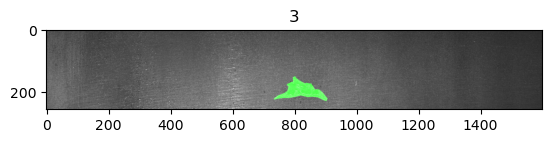

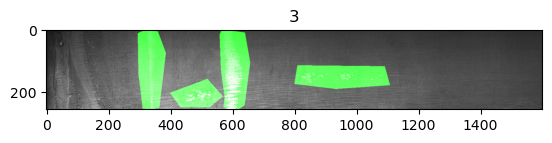

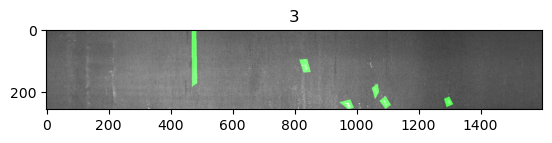

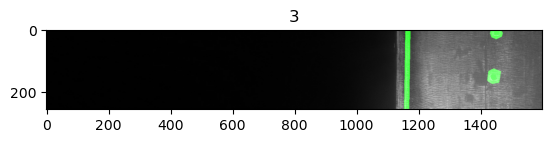

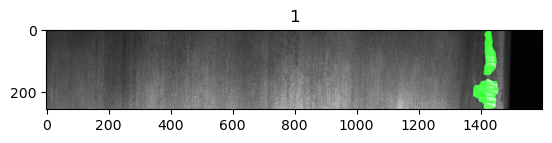

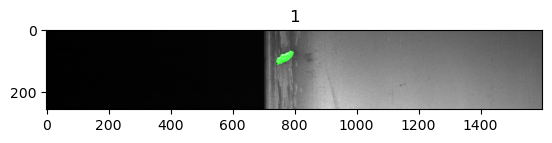

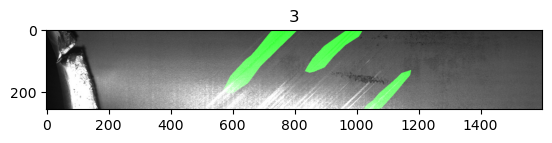

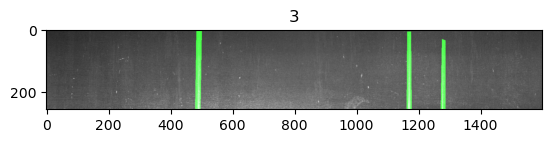

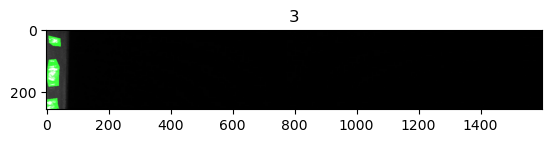

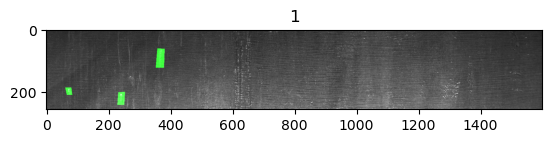

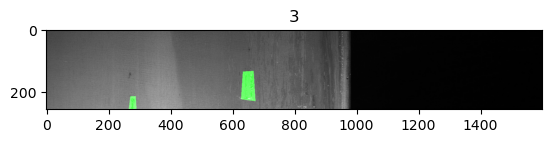

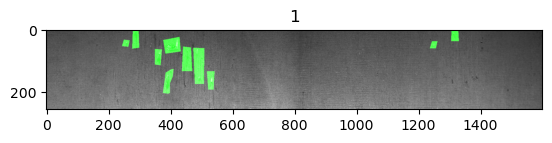

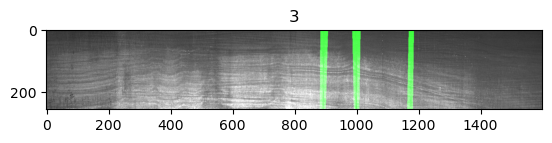

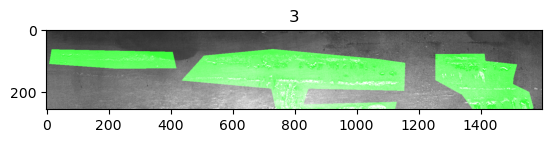

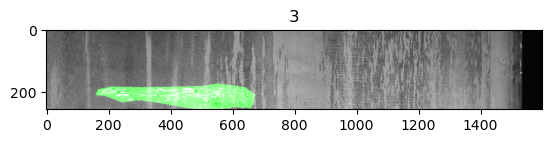

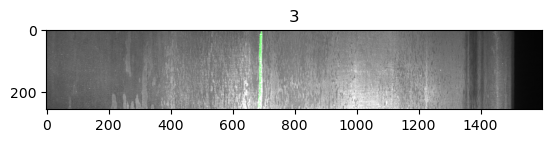

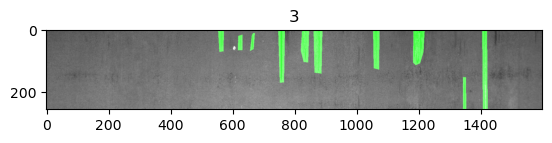

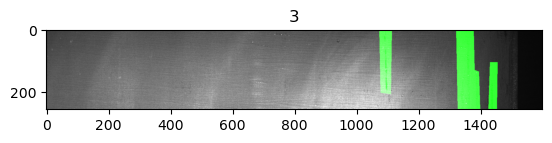

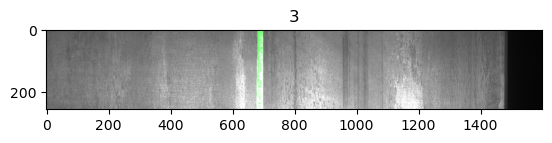

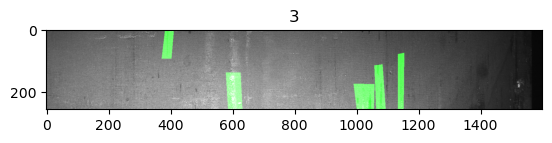

In [66]:
# Show original images with defects

for i in range(20):

    img = io.imread(os.path.join(train_dir, test_df.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = rle2mask(test_df.EncodedPixels[i], img.shape[0], img.shape[1])

    img[mask ==1, 1] = 255     # increase intensity of green color to show defects

    plt.figure()
    plt.title(test_df.ClassId[i])
    plt.imshow(img)

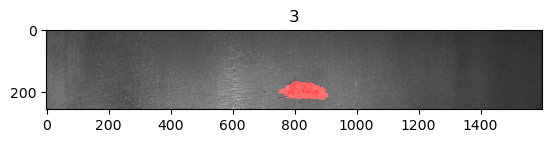

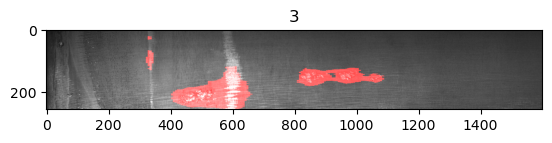

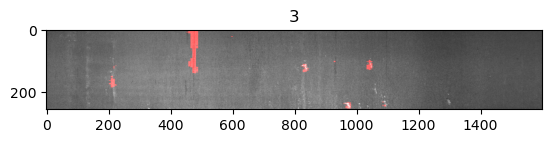

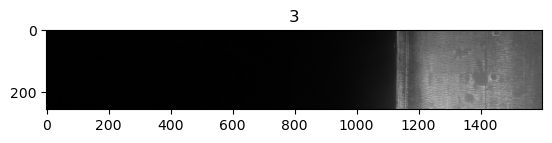

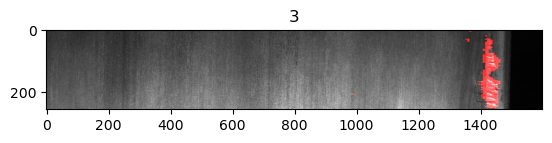

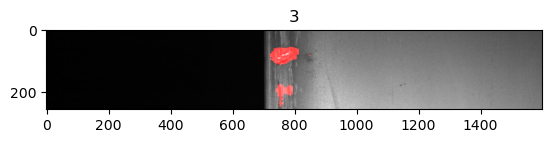

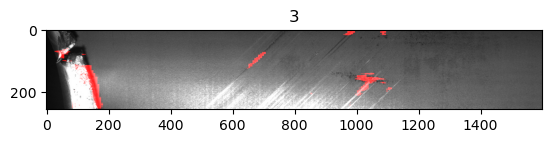

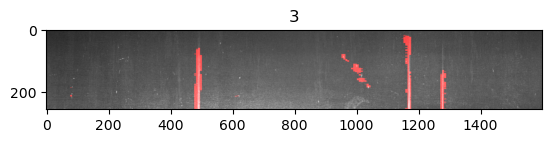

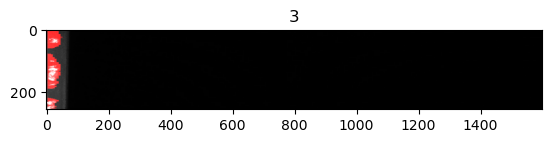

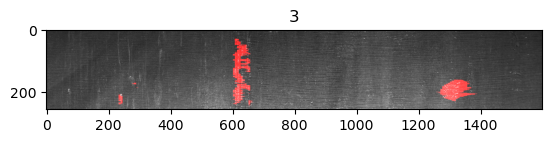

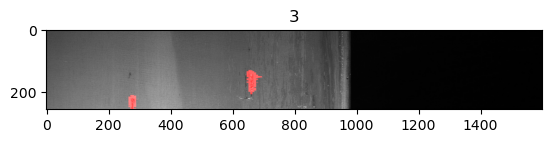

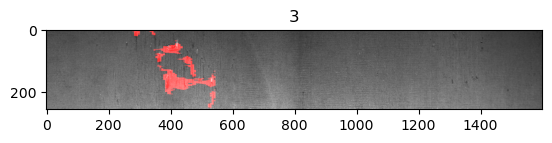

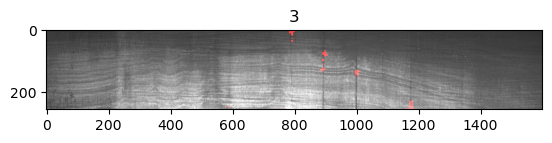

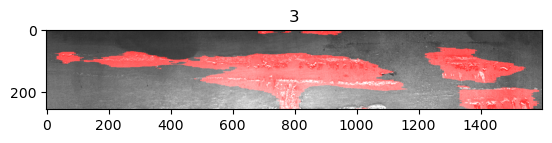

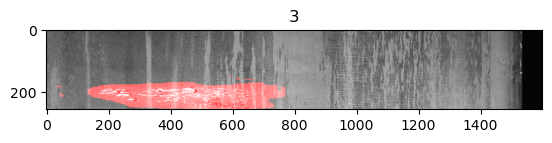

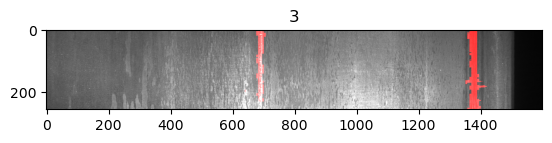

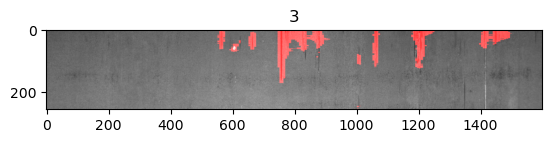

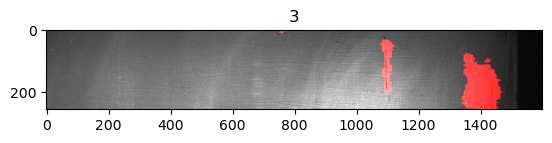

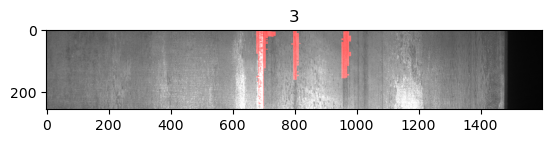

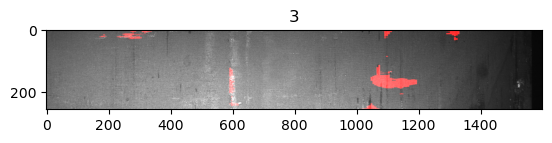

In [67]:
# Show predicted images with defects

directory = 'train_images'

for i in range(20):

    img = io.imread(os.path.join(directory, df_pred.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = rle2mask(df_pred.EncodedPixels[i], img.shape[0], img.shape[1])
    
    img[mask == 1, 0] = 255   #increase intensity of red color to show defects
    
    plt.figure()
    plt.title(df_pred.ClassId[i])
    plt.imshow(img)

We can compare our images with original defect mask in green and predicted defect mask in red. 

In general, in most cases, the model can predict the location of the defect from the pixels. 

## Conclusion

In this project I've used transfer learning with ResUNet to solve the problem of segmentation of defected parts in rolled steel.  

In this project we have 12997 images and encoded pixels with mask, and most of all there were defects with class 3 (about 4000 images) and most images had 1 defect (5201 images).

I've used some functions from 'utilities' file to solve the problem with segmentation.

First of all, I've defined images with and without defects with ResNet and model had accuracy of 79%.

Then, I've trained model with UNet to identify individual cells within the segmentation map. This converts the segmentation problem into a classification problem where I need to classify each pixel to one of the classes.

After comparing images with original defect mask and predicted defect mask we can see that in most cases the model with transfer learning can predict the location of defect.